In [1]:
import numpy as np
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import mlflow
from mlflow.types import Schema, TensorSpec
from mlflow.models import ModelSignature

from sd_vae.ae import VAE
from trainers import EarlyStopping
from trainers.first_stage_trainer import CLEAR_VAEFirstStageTrainer

from modules.loss import SupCon, SNN, DenseSupCon

import data_utils.styled_mnist.corruptions as corruptions
from data_utils.styled_mnist.data_utils import StyledMNISTGenerator, StyledMNIST

%load_ext autoreload
%autoreload 2

In [2]:
from exp_utils.train_utils import load_cfg

cfg = load_cfg('./config/mnist.yaml')


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
mnist = MNIST("./data", train=True, download=False)

In [5]:
np.random.seed(101)
torch.manual_seed(101)

generator = StyledMNISTGenerator(
    mnist,
    {
        # corruptions.identity: 0.1,
        # corruptions.stripe: 0.15,
        # corruptions.zigzag: 0.25,
        # corruptions.canny_edges: 0.15,
        # lambda x: corruptions.scale(x, 5): 0.15,
        # corruptions.brightness: 0.2
        lambda x: corruptions.rgb_change(x, 'red'): 0.2,
        lambda x: corruptions.rgb_change(x, 'green'): 0.2,
        lambda x: corruptions.rgb_change(x, 'blue'): 0.2,
        lambda x: corruptions.rgb_change(x, 'yellow'): 0.2,
        lambda x: corruptions.rgb_change(x, 'magenta'): 0.2,
    },
)
dataset = StyledMNIST(
    generator, 
    transforms.Compose([
        transforms.ToTensor(), 
        lambda img: img / 255.0,
    ])
)

train, test, valid = random_split(dataset, [40000, 10000, 10000])

Generating dataset: 100%|██████████| 60000/60000 [00:03<00:00, 19412.34item/s]


In [6]:
train_loader = DataLoader(train, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid, batch_size=256, shuffle=False)
test_loader = DataLoader(test, batch_size=128, shuffle=False)

In [7]:
import torch.nn as nn
import torch.nn.init as init

def xavier_init(model):
    for m in model.modules():
        if isinstance(m, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
            init.xavier_uniform_(m.weight)
            if m.bias is not None:
                init.zeros_(m.bias)
        elif isinstance(m, nn.BatchNorm2d):
            init.ones_(m.weight)
            init.zeros_(m.bias)

In [8]:
params = {
    "lr": 1e-3,
    "optimizer": "Adam",
    "batch_size": 256,
    "channel_split": [4, 8],
    "beta": 1 / 10,
    "gamma_c": 10000,
    "gamma_s": 10000,
    "z_channels": 12,
    "contrastive_module": {
        "contrastive_method": "SNN",
        "temperature": [0.1, 1],
        "learnable_temp": True,
        "pool": "gap",
        "use_proj": True,
        "use_dense": False,
    },
}

input_schema = Schema([TensorSpec(np.dtype(np.float32), [-1, 1, 32, 32])])
output_schema = Schema([TensorSpec(np.dtype(np.float32), [-1, 1, 32, 32])])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

vae = VAE(**cfg['vae']).to(device)

vae.apply(xavier_init)

trainer = CLEAR_VAEFirstStageTrainer(
    model=vae,
    early_stopping=EarlyStopping(patience=8),
    verbose_period=2,
    device="cuda",
    model_signature=signature,
    args=cfg["trainer_param"],
)

In [10]:
mlflow.set_tracking_uri("./mlruns")
mlflow.set_experiment("test")
with mlflow.start_run() as run:
    mlflow.log_params(params)
    trainer.fit(epochs=1, train_loader=train_loader, valid_loader=valid_loader)

100%|██████████| 40/40 [00:01<00:00, 29.33batch/s]


epoch 0/val_rec: 84.0307
[INFO]: track model state
[INFO]: log best model


In [11]:
run.info.run_id

'21876b53b92d4f4593c181d69aea0a03'

In [14]:
print("content tau:", trainer.contrastive_criterions['global']['content'].log_tau.exp().item())
print("style tau:", trainer.contrastive_criterions['global']['style'].log_tau.exp().item())


content tau: 0.0935676321387291
style tau: 1.0518662929534912


In [12]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

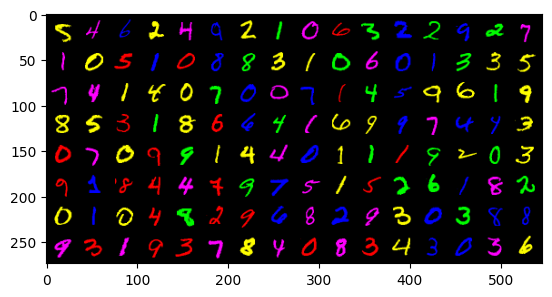

In [13]:
batch = next(iter(test_loader))
x, y = batch['image'].to("cuda"), batch['label'].to("cuda")
plt.imshow(make_grid(x, nrow=16).cpu().permute(1,2,0))

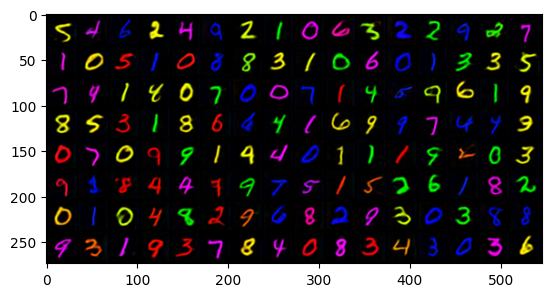

In [15]:
x = next(iter(test_loader))['image'].to("cuda")
best_model = mlflow.pytorch.load_model('runs:/f167d73aba3b457d871ea2c5443c34c2/best_model')
with torch.no_grad():
    best_model.eval()
    xhat, posterior = best_model(x)
    plt.imshow(make_grid(xhat, nrow=16).cpu().permute(1,2,0))

In [16]:
from mlflow.tracking import MlflowClient

run = MlflowClient().get_run("f167d73aba3b457d871ea2c5443c34c2")
channel_split = eval(run.data.params['channel_split'])

In [ ]:
mu = posterior.mu
print(mu.shape)
for i in range(mu.shape[1]):
    plt.imshow(make_grid(mu[:,i][:,None,:,:], nrow=16).cpu().permute(1,2,0))
    plt.show()

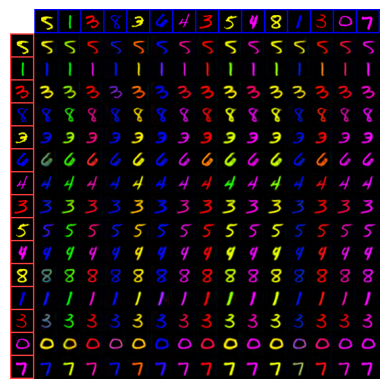

In [23]:
from exp_utils.visual import feature_swapping_plot

z_c, z_s = mu.split_with_sizes(params['channel_split'], dim=1)
x = next(iter(test_loader))['image'].to("cuda")

select = torch.randint(0, 128, (15,)).tolist()
feature_swapping_plot(
    z_c[select],
    z_s[select],
    x[select],
    best_model,
    out_dir="./out/mnist",
    run_id=run.info.run_id,
)

In [ ]:
z_cs = []
z_ss = []
labels = []
styles = []

with torch.no_grad():
    best_model.eval()
    for batch in tqdm(test_loader):
        x = batch['image'].to(device)
        _, posterior = best_model(x)
        z_c, z_s = posterior.sample().split_with_sizes(channel_split, dim=1)
        z_cs.append(z_c.cpu())
        z_ss.append(z_s.cpu())
        labels.append(batch['label'])
        styles.append(batch['style'])

z_cs = torch.cat(z_cs, dim=0)
z_ss = torch.cat(z_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)


In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2, init='pca')
z_2d = tsne.fit_transform(z_cs.view(z_cs.shape[0], -1).numpy())

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs0 = axs[0].scatter(z_2d[:, 0], z_2d[:, 1], c=labels.numpy(), cmap='tab10', alpha=0.2)
cbar = fig.colorbar(axs0, ax=axs[0])
axs[0].set_title('color by content')

# style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'scale','brightness']
style_labels = ['red', 'green', 'blue', 'yellow', 'purple']
cmap = plt.get_cmap('Set1')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    axs[1].scatter(z_2d[i,0], z_2d[i,1], alpha=0.2, c=colors[g], label=style_labels[g])
axs[1].legend()
plt.show()

In [ ]:
tsne = TSNE(n_components=2, init='pca', perplexity=100, learning_rate=800, max_iter=8000, early_exaggeration=40)
z_2d = tsne.fit_transform(z_ss.view(z_ss.shape[0], -1).numpy())

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs0 = axs[0].scatter(z_2d[:, 0], z_2d[:, 1], c=labels.numpy(), cmap='tab10', alpha=0.2)
cbar = fig.colorbar(axs0, ax=axs[0])
axs[0].set_title('color by content')

# style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'scale','brightness']
style_labels = ['red', 'green', 'blue', 'yellow'
                , 'purple']
cmap = plt.get_cmap('Set1')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    axs[1].scatter(z_2d[i,0], z_2d[i,1], alpha=0.2, c=colors[g], label=style_labels[g])
axs[1].legend()
plt.show()